In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random as random

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# supressing warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (28, 14)


In [2]:
def plot_year(df, year):
    for i in range(len(year)):
        r = random.random()
        b = random.random()
        g = random.random()
        rgb_color = (r, g, b)
        sns.lineplot(df.loc[year[i]].index.dayofyear, df.loc[year[i]]['temp'], color=rgb_color, label=str(year[i]))


In [3]:
df = pd.read_csv('ECA_blended_custom/temp_data.txt', delimiter=',', skiprows=19)

In [4]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43830 entries, 0 to 43829
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    43830 non-null  int64
 1       DATE  43830 non-null  int64
 2      TG     43830 non-null  int64
 3    Q_TG     43830 non-null  int64
dtypes: int64(4)
memory usage: 1.3 MB


In [5]:
df.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [6]:
df.rename({' SOUID' : 'id', '    DATE' : 'date','   TG' : 'temp', ' Q_TG': 'quality'}, axis=1, inplace=True)
#df.columns = ['id', 'date' , 'temp' , 'quality']


In [7]:
df['quality'].value_counts()

0    43635
9      195
Name: quality, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43830 entries, 0 to 43829
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       43830 non-null  int64
 1   date     43830 non-null  int64
 2   temp     43830 non-null  int64
 3   quality  43830 non-null  int64
dtypes: int64(4)
memory usage: 1.3 MB


In [9]:
df.loc[df['quality']==9].head()

,id,date,temp,quality
16185,127488,19450425,-9999,9
16186,127488,19450426,-9999,9
16187,127488,19450427,-9999,9
16188,127488,19450428,-9999,9
16189,127488,19450429,-9999,9


In [10]:
df['date'] = df['date'].astype(str)

df['date'] = pd.to_datetime(df['date'])


In [11]:
df.head()

,id,date,temp,quality
0,127488,1901-01-01,-84,0
1,127488,1901-01-02,-119,0
2,127488,1901-01-03,-128,0
3,127488,1901-01-04,-116,0
4,127488,1901-01-05,-100,0


In [12]:
df.set_index(df['date'], inplace= True)

In [13]:
df.tail()

,id,date,temp,quality
date,,,,
2020-12-27,121152,2020-12-27,17,0
2020-12-28,121152,2020-12-28,30,0
2020-12-29,121152,2020-12-29,23,0
2020-12-30,121152,2020-12-30,24,0
2020-12-31,121152,2020-12-31,28,0


In [14]:
df.drop(df[df['temp'] == -9999].index, axis = 0, inplace=True)

In [15]:
df['quality'].value_counts()

0    43635
Name: quality, dtype: int64

In [16]:
df.drop(['id', 'quality', 'date'], axis=1, inplace=True)

In [17]:
df.head()

,temp
date,
1901-01-01,-84
1901-01-02,-119
1901-01-03,-128
1901-01-04,-116
1901-01-05,-100


In [18]:
df['temp'] = df['temp']*0.1
df.head()

,temp
date,
1901-01-01,-8.4
1901-01-02,-11.9
1901-01-03,-12.8
1901-01-04,-11.6
1901-01-05,-10.0


In [19]:
# f, ax = plt.subplots(figsize=(20, 10))

# sns.set_theme(style="darkgrid")

# # Plot the responses for different events and regions
# #sns.lineplot(x=df.loc["1990":"2021"].index, y="temp_c", data=df.loc["1990":"2021"], ax=ax)
# #sns.lineplot(x=df.loc["1990":"1993"].index,y=df.loc["1990":"1993"]['temp_c'], data=df.loc["1990":"1993"], ax=ax)
# sns.lineplot(x=df.loc["1990": '1991'].index, y= 'temp_c', data=df.loc["1990":"1991"], ax=ax)
# plt.show()


In [20]:
train_df = df.loc[:'2019']

In [21]:
test_df = df.loc['2020']
test_df.head()

,temp
date,
2020-01-01,1.7
2020-01-02,0.5
2020-01-03,4.5
2020-01-04,3.9
2020-01-05,1.2


In [22]:
train_df.to_csv('train_data.csv')
test_df.to_csv('test_data.csv')

In [23]:
train_df['timestep'] = list(range(len(train_df)))

In [24]:
# Run a Linear Regression
m = LinearRegression()
X = train_df[['timestep']]
y = train_df['temp']
m.fit(X, y)


LinearRegression()

In [25]:
train_df['trend'] = m.predict(X)

<AxesSubplot:xlabel='date'>

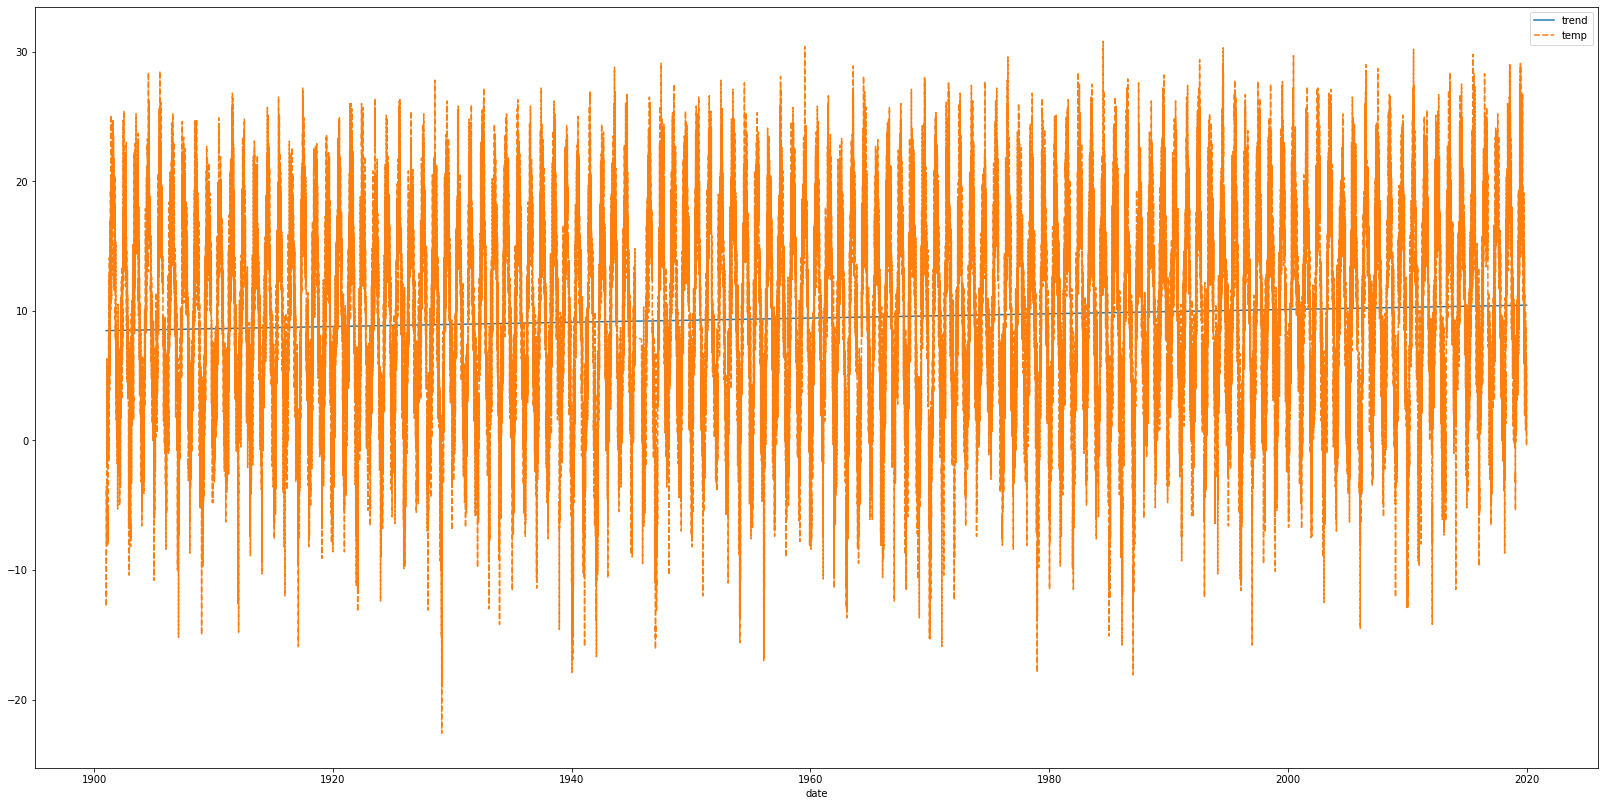

In [26]:
sns.lineplot(data=train_df[['trend','temp']])

In [27]:
train_df['day'] = train_df.index.day.astype('category')
train_df['month_name'] = train_df.index.month_name()
train_df.head()


,temp,timestep,trend,day,month_name
date,,,,,
1901-01-01,-8.4,0,8.472556,1,January
1901-01-02,-11.9,1,8.472602,2,January
1901-01-03,-12.8,2,8.472647,3,January
1901-01-04,-11.6,3,8.472693,4,January
1901-01-05,-10.0,4,8.472738,5,January


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43269 entries, 1901-01-01 to 2019-12-31
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   temp        43269 non-null  float64 
 1   timestep    43269 non-null  int64   
 2   trend       43269 non-null  float64 
 3   day         43269 non-null  category
 4   month_name  43269 non-null  object  
dtypes: category(1), float64(2), int64(1), object(1)
memory usage: 1.7+ MB


In [29]:
train_df = train_df.join(pd.get_dummies(train_df['day'], prefix='', prefix_sep='', drop_first=True))
train_df = train_df.join(pd.get_dummies(train_df['month_name'], prefix='', prefix_sep='', drop_first=True))
train_df.head()


,temp,timestep,trend,day,month_name,2,3,4,5,6,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
1901-01-01,-8.4,0,8.472556,1,January,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1901-01-02,-11.9,1,8.472602,2,January,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1901-01-03,-12.8,2,8.472647,3,January,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1901-01-04,-11.6,3,8.472693,4,January,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1901-01-05,-10.0,4,8.472738,5,January,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [30]:
# Define X and y

# X is timestep and month dummies
X = train_df.drop(columns=['temp','trend','month_name','day'])

y = train_df['temp']


In [31]:
m.fit(X,y)
m.score(X,y)

0.7456477669811946

In [32]:
train_df['trend_daily'] = m.predict(X)

<AxesSubplot:xlabel='date'>

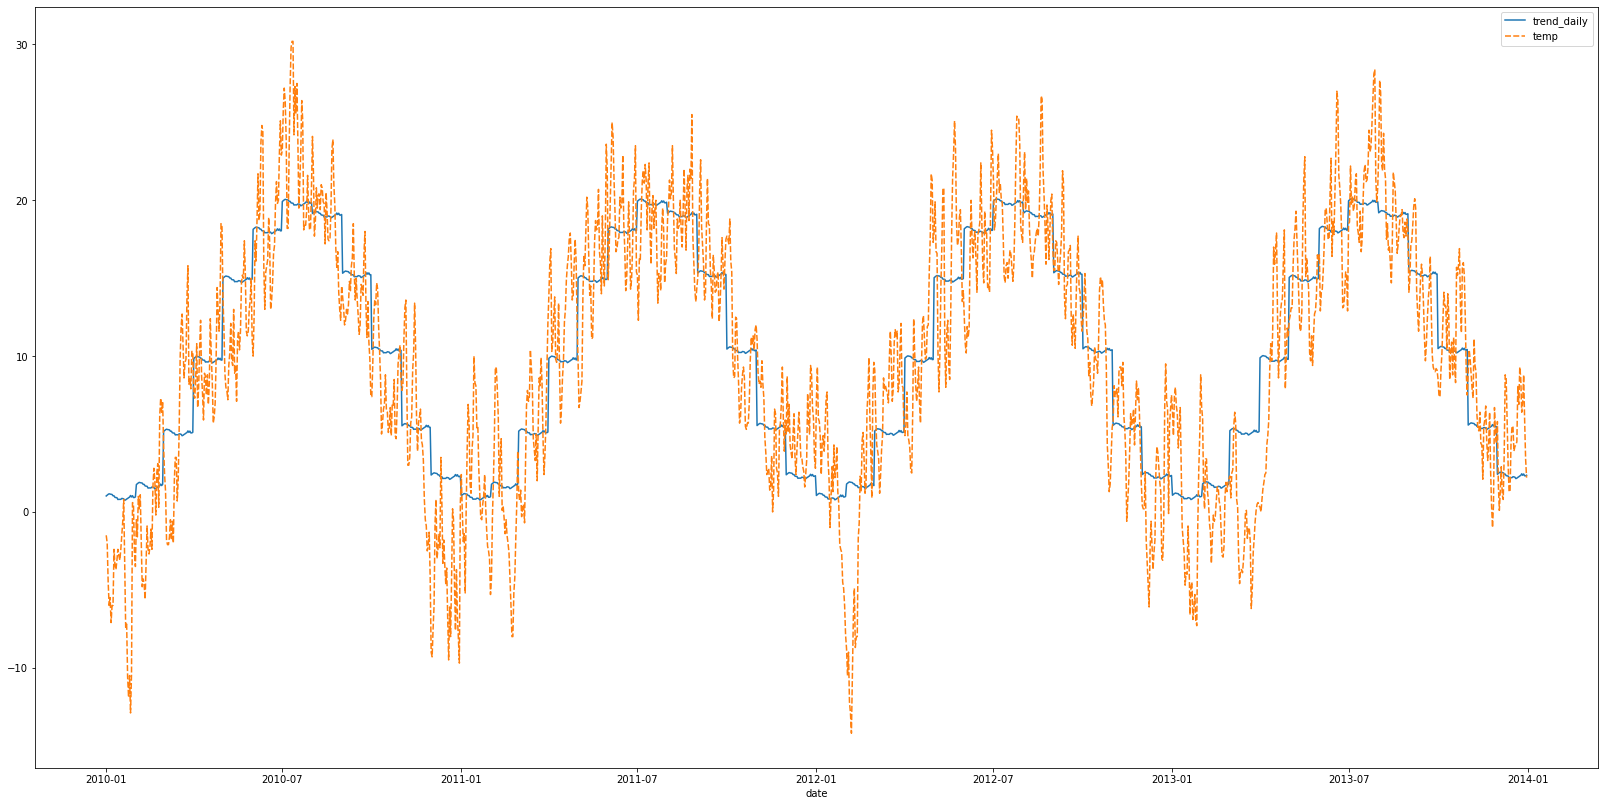

In [33]:
sns.lineplot(data=train_df.loc['2010':'2013'][['trend_daily', 'temp']])

<AxesSubplot:xlabel='date'>

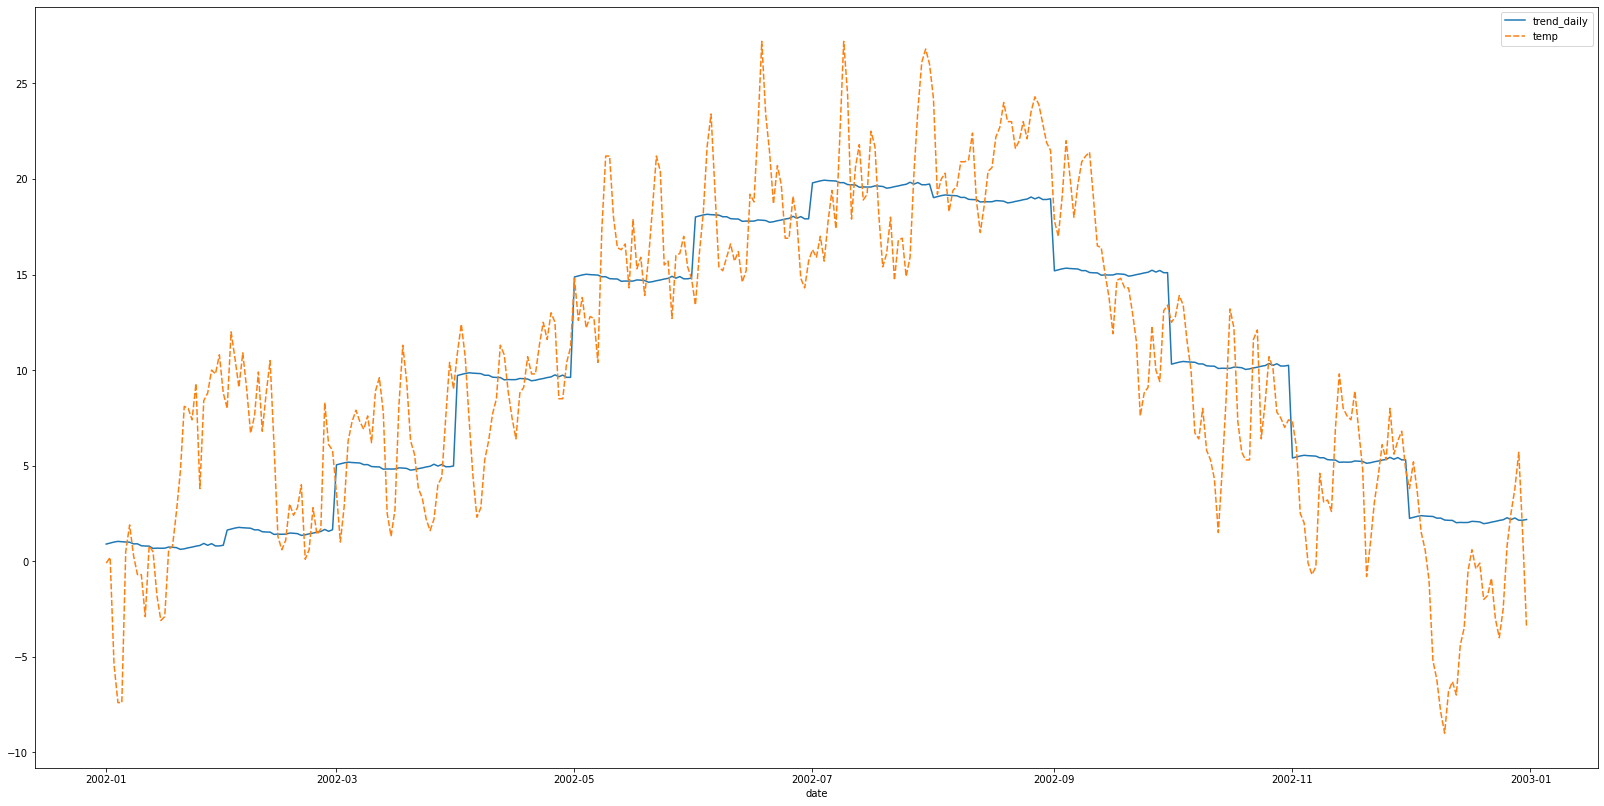

In [34]:
sns.lineplot(data=train_df.loc['2002'][['trend_daily', 'temp']])

<AxesSubplot:xlabel='date', ylabel='remainder'>

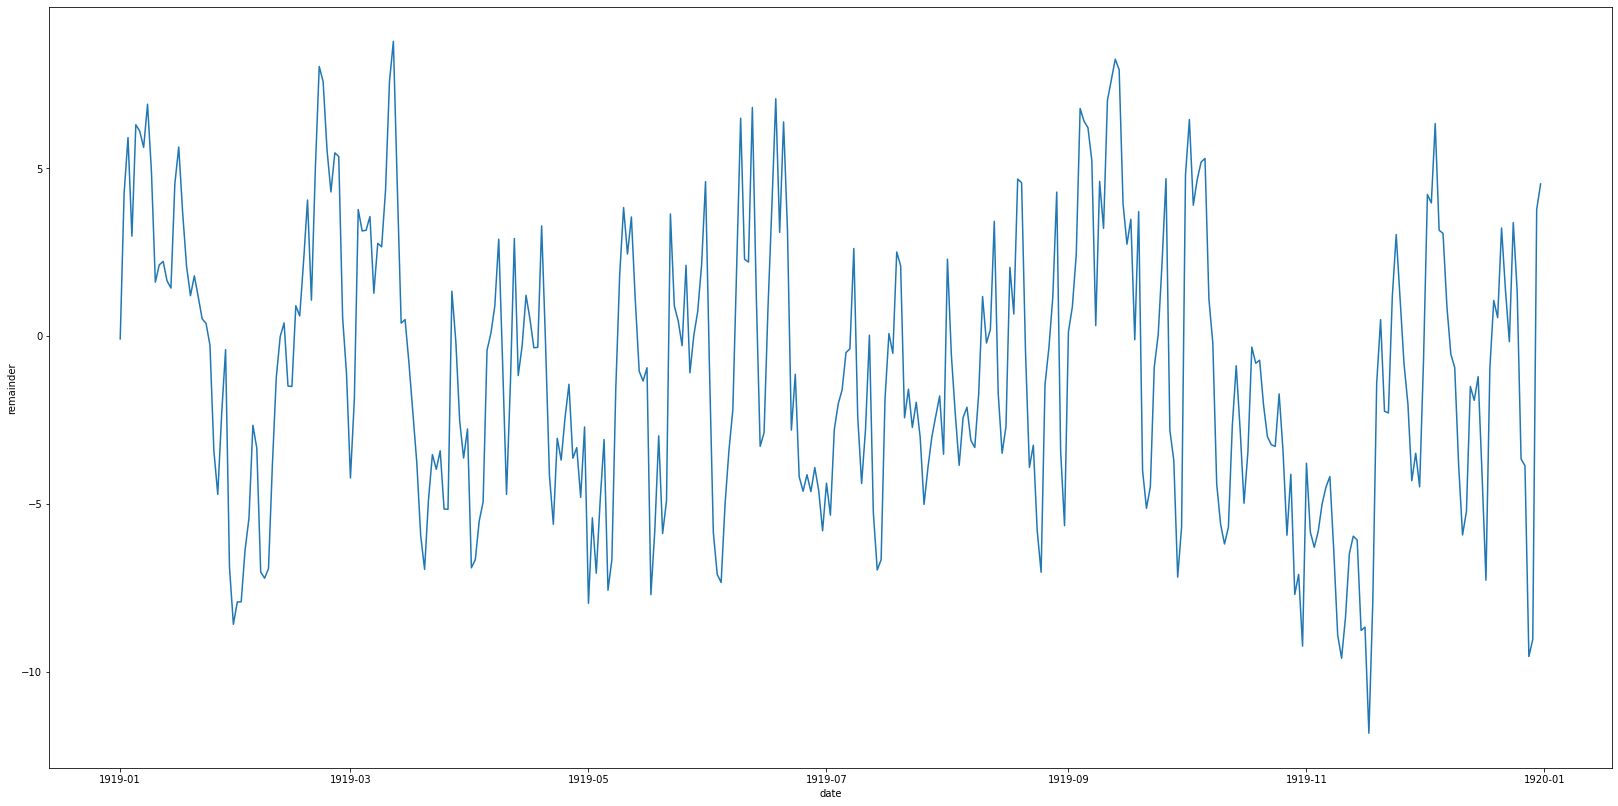

In [35]:
train_df['remainder'] = train_df['temp'] - train_df['trend_daily']
sns.lineplot(data=train_df.loc['1919'].remainder)

In [36]:
train_df.remainder.to_csv('remainder.csv')

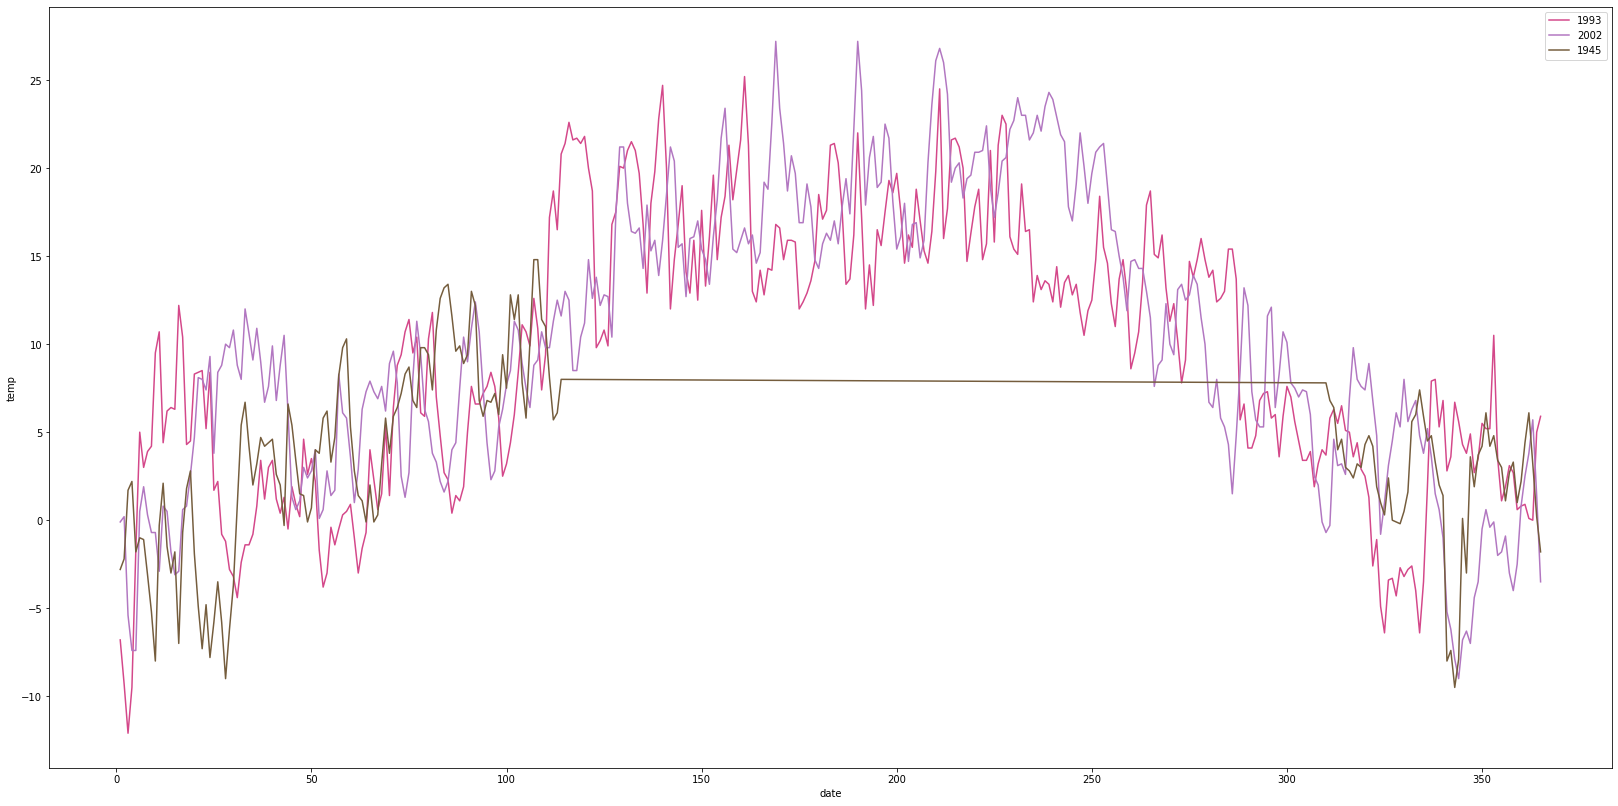

In [37]:
plot_year(train_df, ["1993",'2002','1945'])


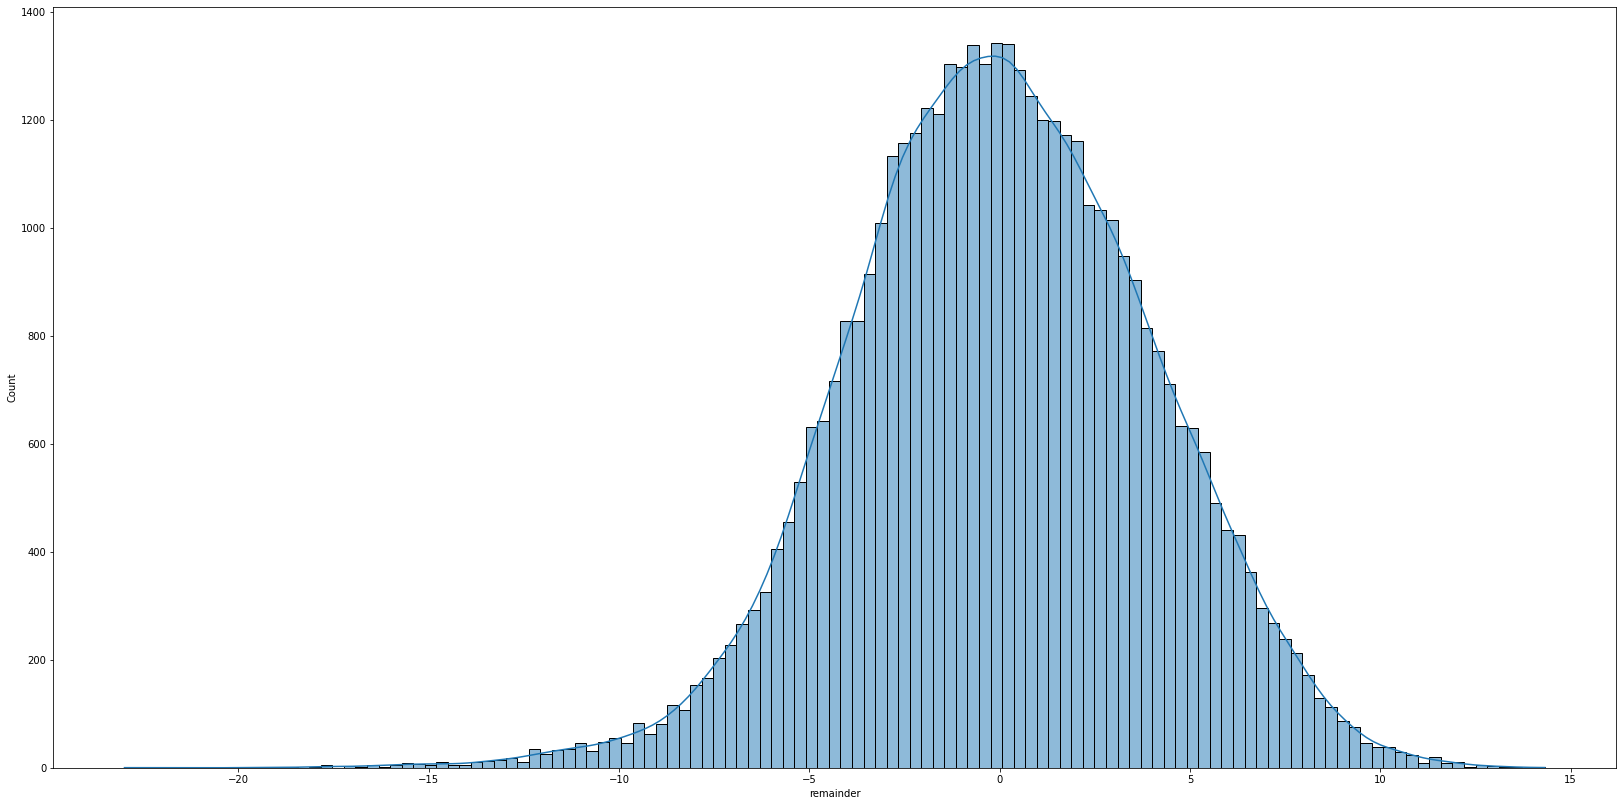

In [38]:
# plotting the distribution of the remainder
sns.histplot(train_df['remainder'], kde=True)
plt.show()


In [39]:
train_df['remainder'].std(), train_df['remainder'].mean()


(3.971305913088427, -1.181569395982773e-15)

<AxesSubplot:xlabel='date'>

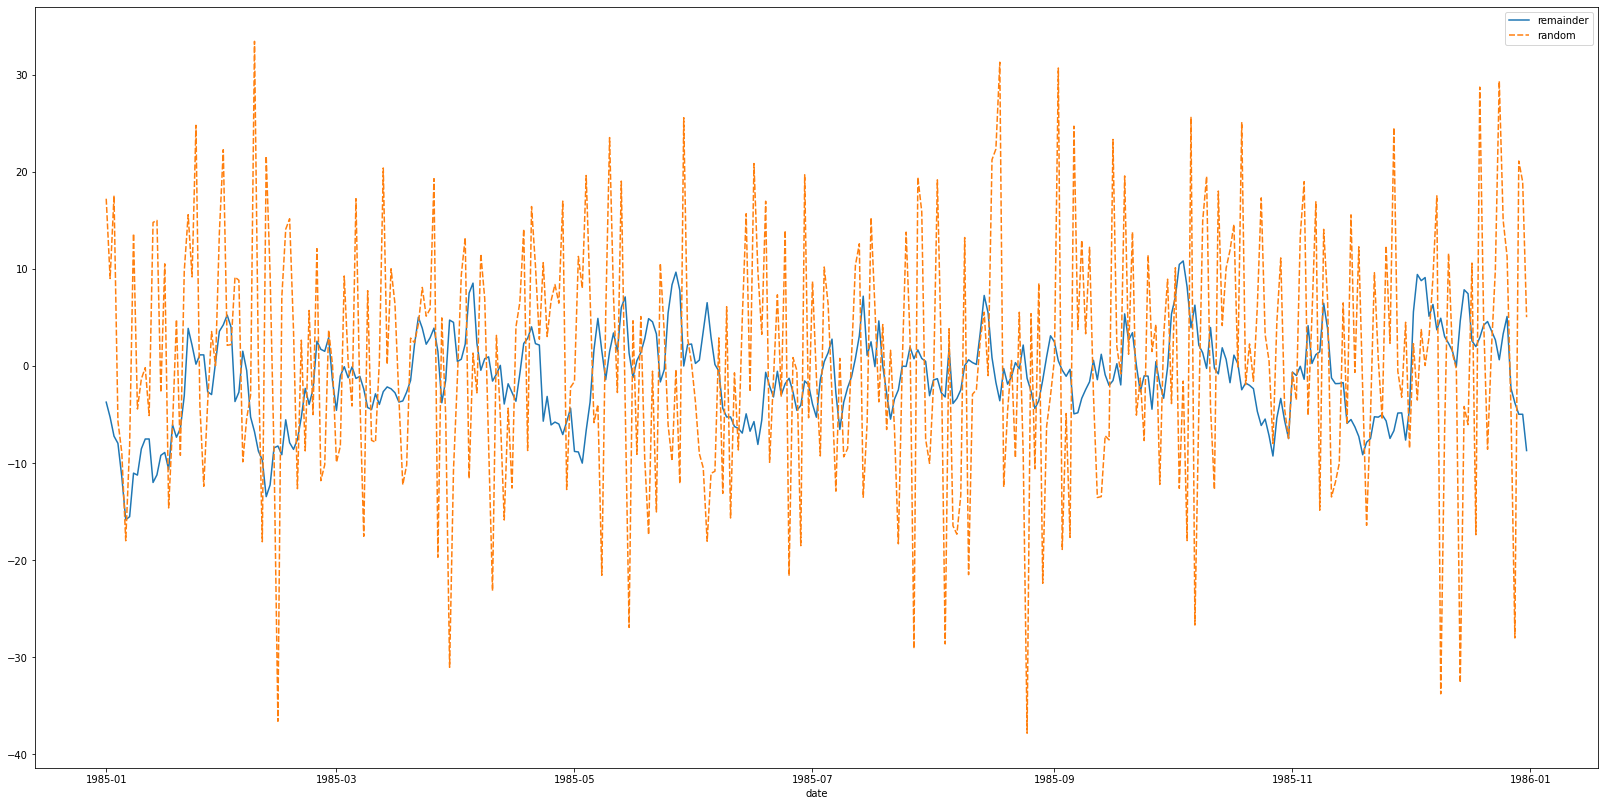

In [40]:
# plot and compare with a random signal
train_df['random'] = np.random.normal(loc=0, scale=12, size=train_df.shape[0])
sns.lineplot(data = train_df.loc['1985'][['remainder', 'random']])


In [41]:
remainder = train_df[['remainder']].copy()
remainder.head()

,remainder
date,
1901-01-01,-7.697368
1901-01-02,-11.251414
1901-01-03,-12.202083
1901-01-04,-11.038184
1901-01-05,-9.418339


In [42]:
remainder['lag1'] = remainder.shift(1)  # shifting by one step == day
remainder.head()

,remainder,lag1
date,,
1901-01-01,-7.697368,NaN
1901-01-02,-11.251414,-7.697368
1901-01-03,-12.202083,-11.251414
1901-01-04,-11.038184,-12.202083
1901-01-05,-9.418339,-11.038184


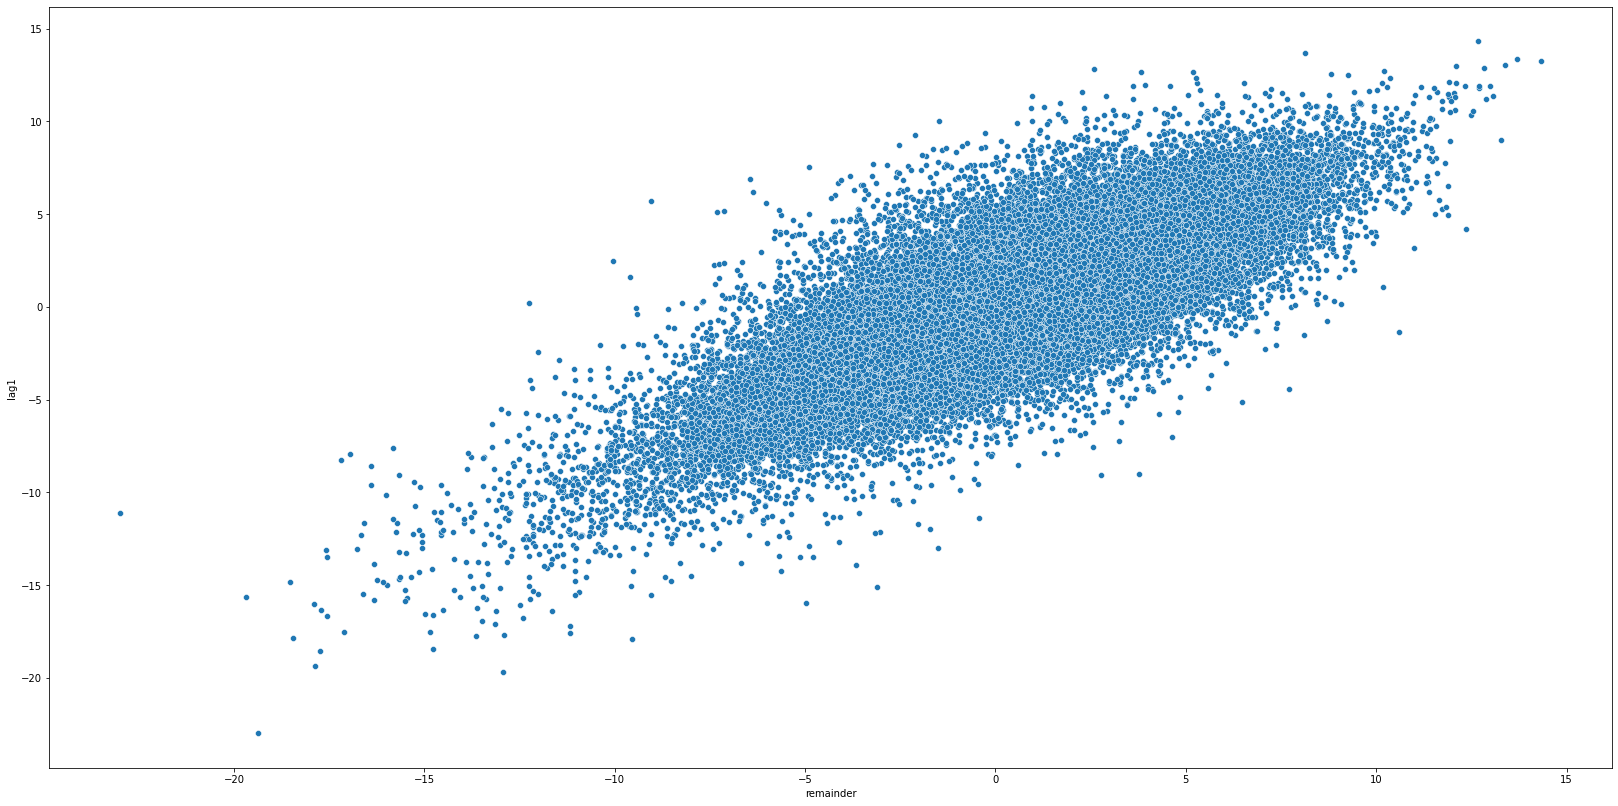

In [43]:
sns.scatterplot(x='remainder',  y='lag1', data=remainder)
plt.show()

In [44]:
remainder['remainder'].corr(remainder['lag1'])

0.7996402178483646

In [45]:
remainder_copy = remainder.copy()
remainder_copy.head()

,remainder,lag1
date,,
1901-01-01,-7.697368,NaN
1901-01-02,-11.251414,-7.697368
1901-01-03,-12.202083,-11.251414
1901-01-04,-11.038184,-12.202083
1901-01-05,-9.418339,-11.038184


In [46]:
# we have to drop the NaN
remainder.dropna(inplace=True)
remainder.head()

,remainder,lag1
date,,
1901-01-02,-11.251414,-7.697368
1901-01-03,-12.202083,-11.251414
1901-01-04,-11.038184,-12.202083
1901-01-05,-9.418339,-11.038184
1901-01-06,-11.308906,-9.418339


In [47]:
# simply a linear regression
X = remainder[['lag1']]  # only feature is the lagged remainder
y = remainder['remainder']

m_ar = LinearRegression()

m_ar.fit(X, y)

remainder['prediction_ar1'] = m_ar.predict(X)

remainder.head()


,remainder,lag1,prediction_ar1
date,,,
1901-01-02,-11.251414,-7.697368,-6.154667
1901-01-03,-12.202083,-11.251414,-8.996524
1901-01-04,-11.038184,-12.202083,-9.756690
1901-01-05,-9.418339,-11.038184,-8.826023
1901-01-06,-11.308906,-9.418339,-7.530776


<AxesSubplot:xlabel='date'>

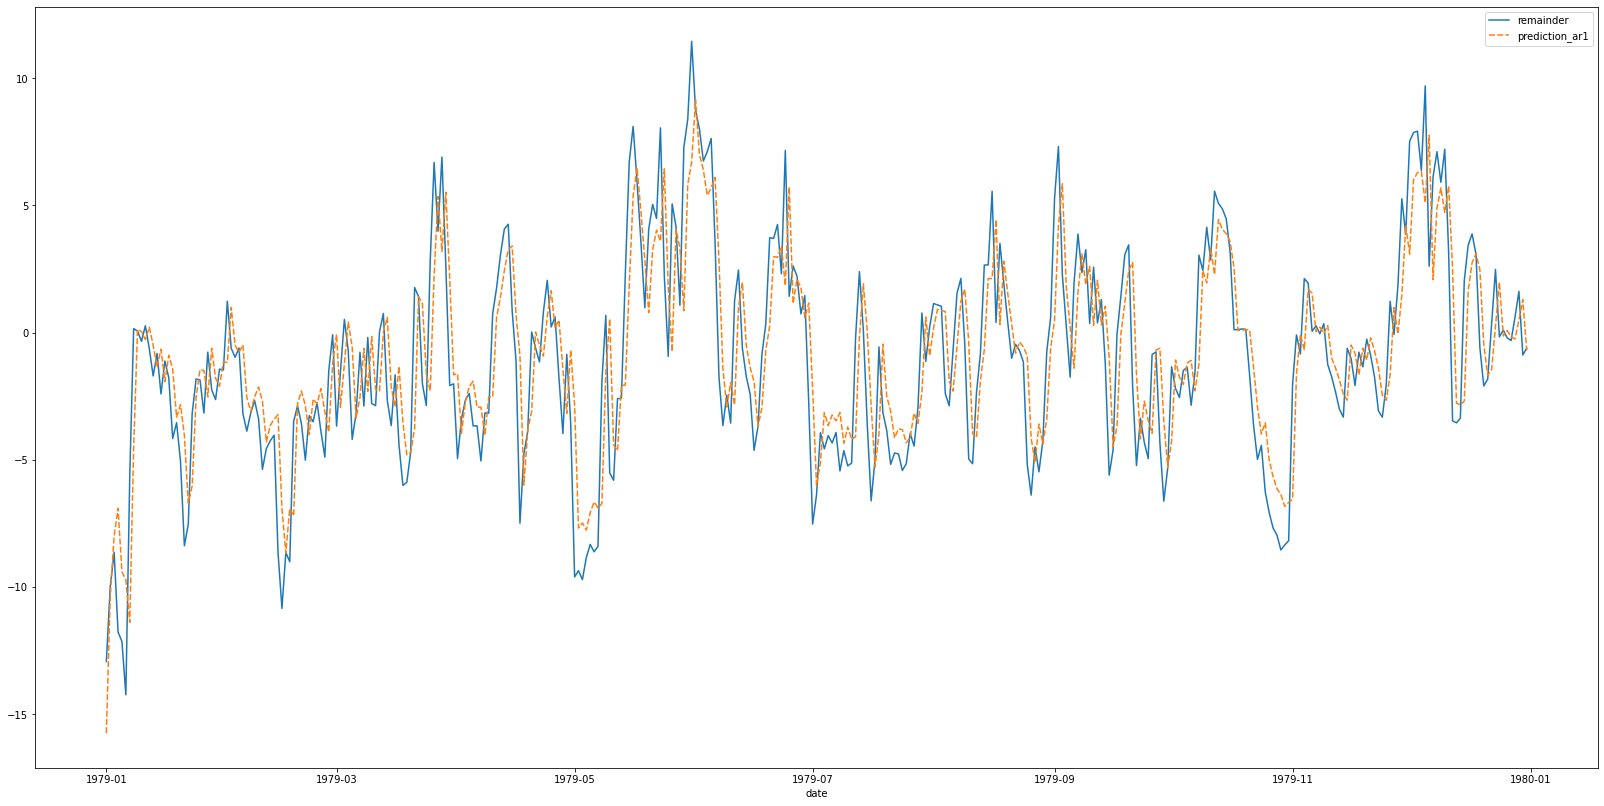

In [50]:
# let's plot the remainder and its AR(1) prediction
sns.lineplot(data=remainder.loc['1979'][['remainder', 'prediction_ar1']])


<AxesSubplot:xlabel='date', ylabel='residual'>

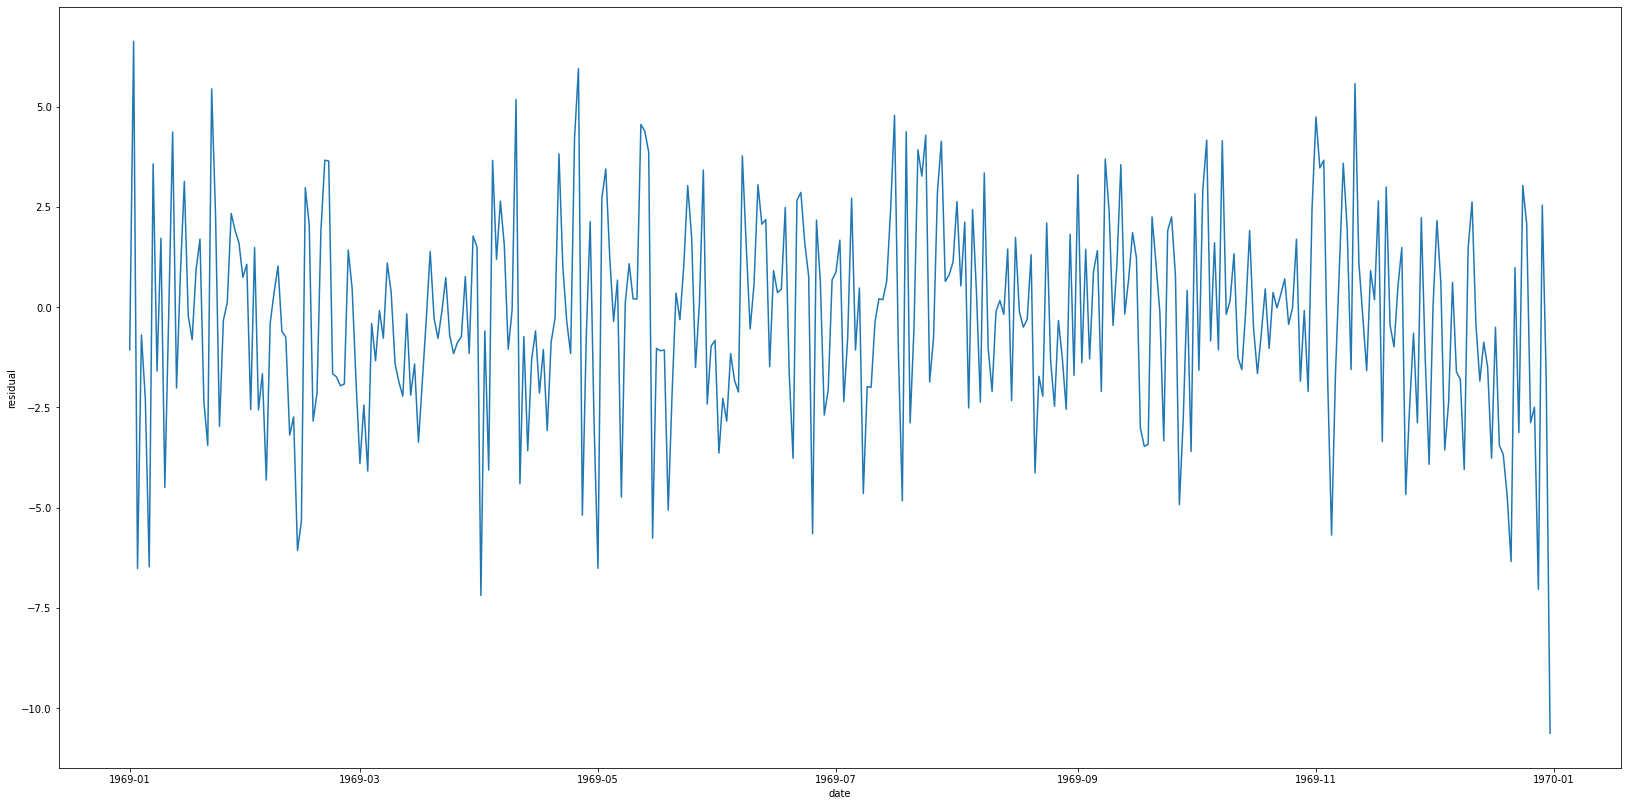

In [53]:
# let's look at the residuals of this ar1 model
remainder['residual'] = remainder['remainder'] - remainder['prediction_ar1']
sns.lineplot(data=remainder.loc['1969']['residual'])

In [54]:
remainder['residual'].mean()

4.50216630999191e-17

In [55]:
remainder_copy['lag2'] = remainder['lag1'].shift(1)
remainder_copy.head()

,remainder,lag1,lag2
date,,,
1901-01-01,-7.697368,NaN,NaN
1901-01-02,-11.251414,-7.697368,NaN
1901-01-03,-12.202083,-11.251414,-7.697368
1901-01-04,-11.038184,-12.202083,-11.251414
1901-01-05,-9.418339,-11.038184,-12.202083


In [56]:
remainder_copy['remainder'].corr(remainder_copy['lag2'])

0.5945056285067188

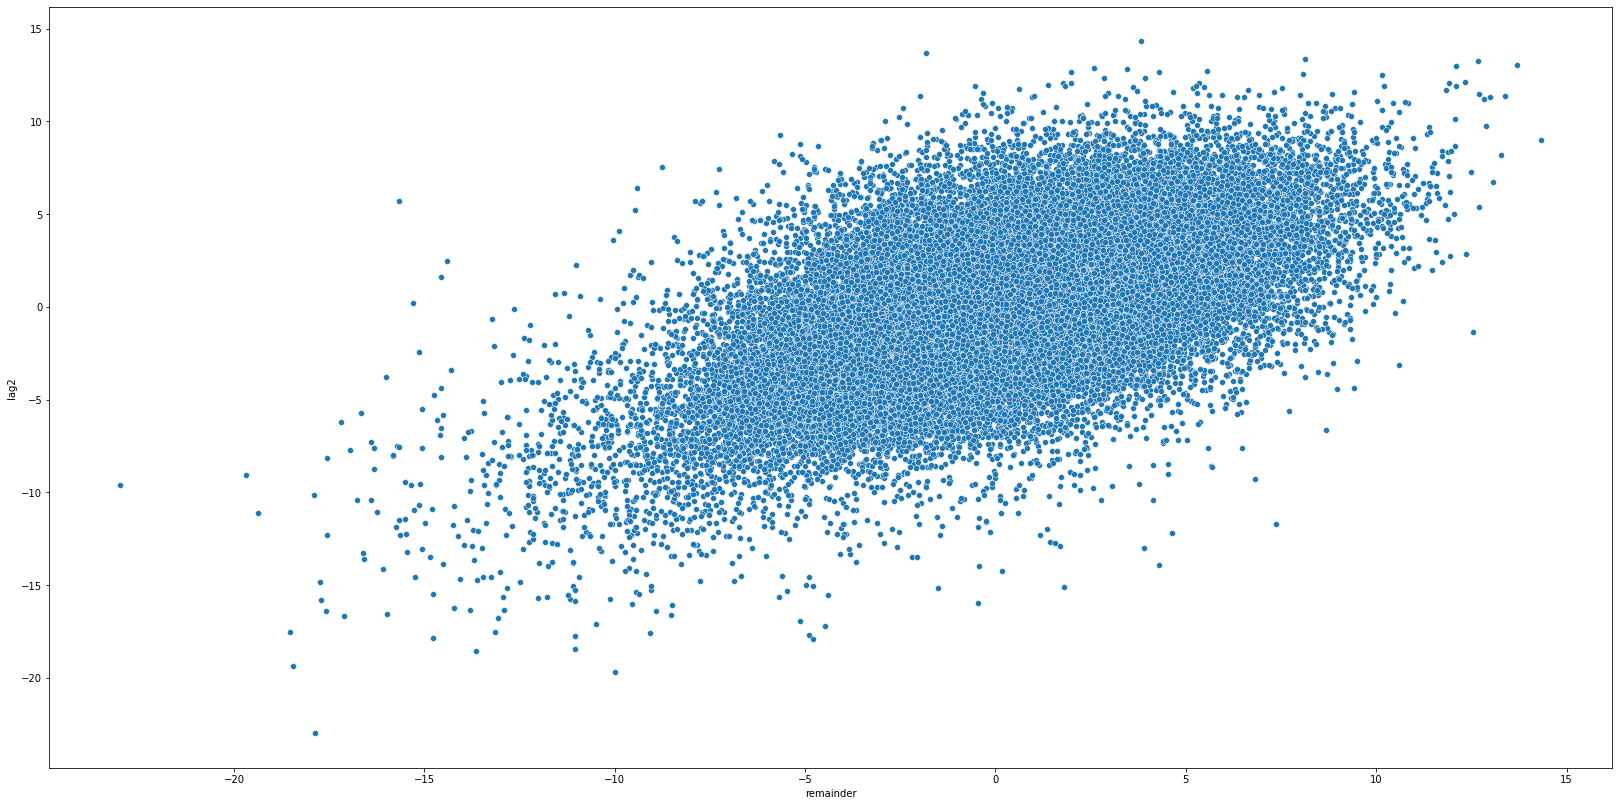

In [57]:
sns.scatterplot(x='remainder',  y='lag2', data=remainder_copy)
plt.show()

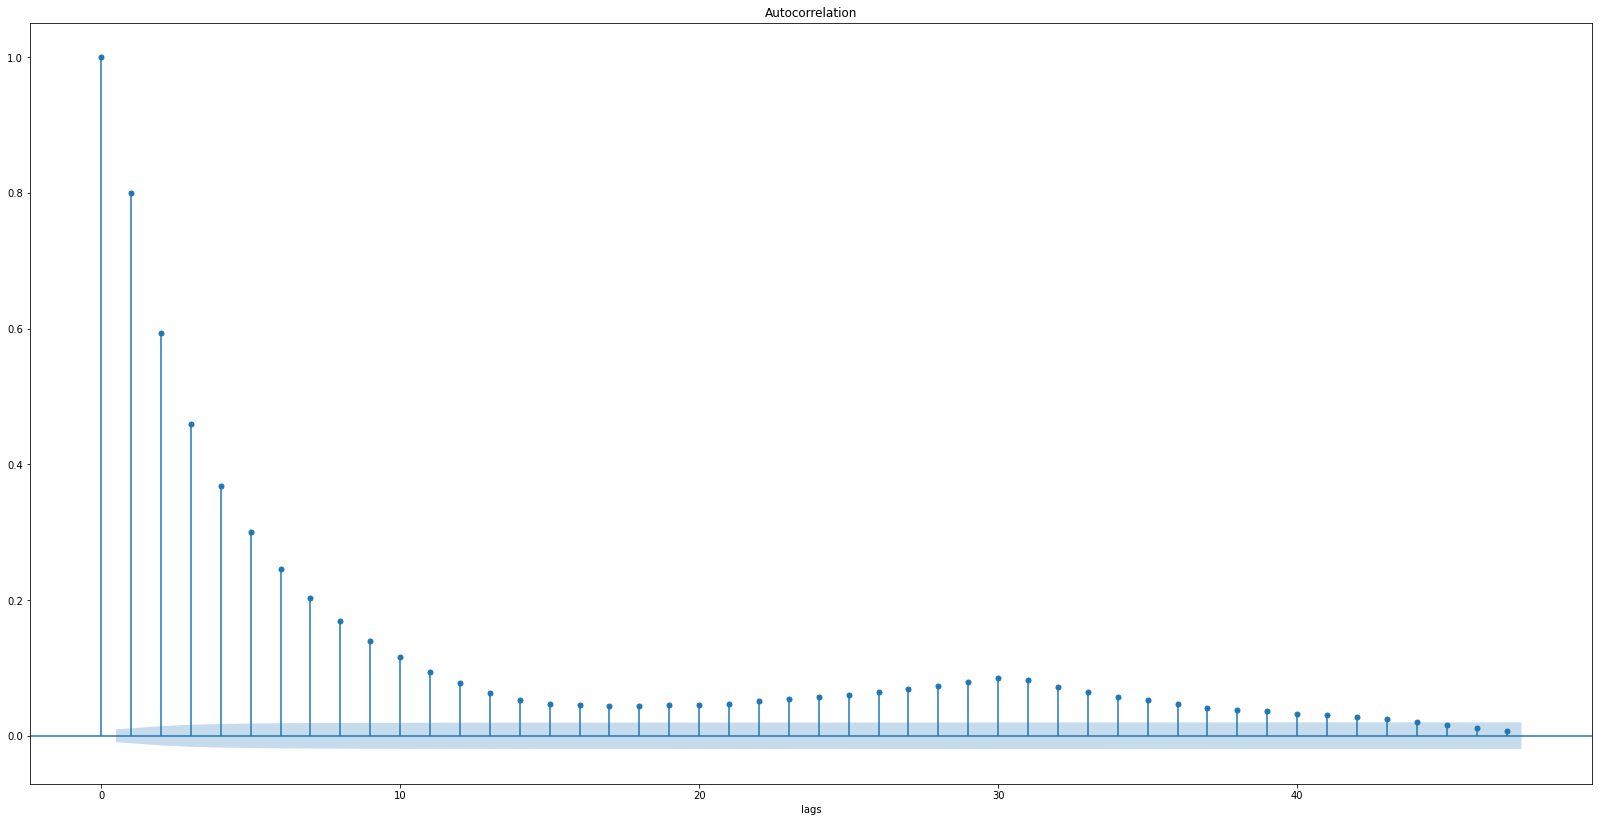

In [58]:
# we can plot auto-correlation with stats model

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(remainder['remainder'])
plt.xlabel('lags')

plt.show()


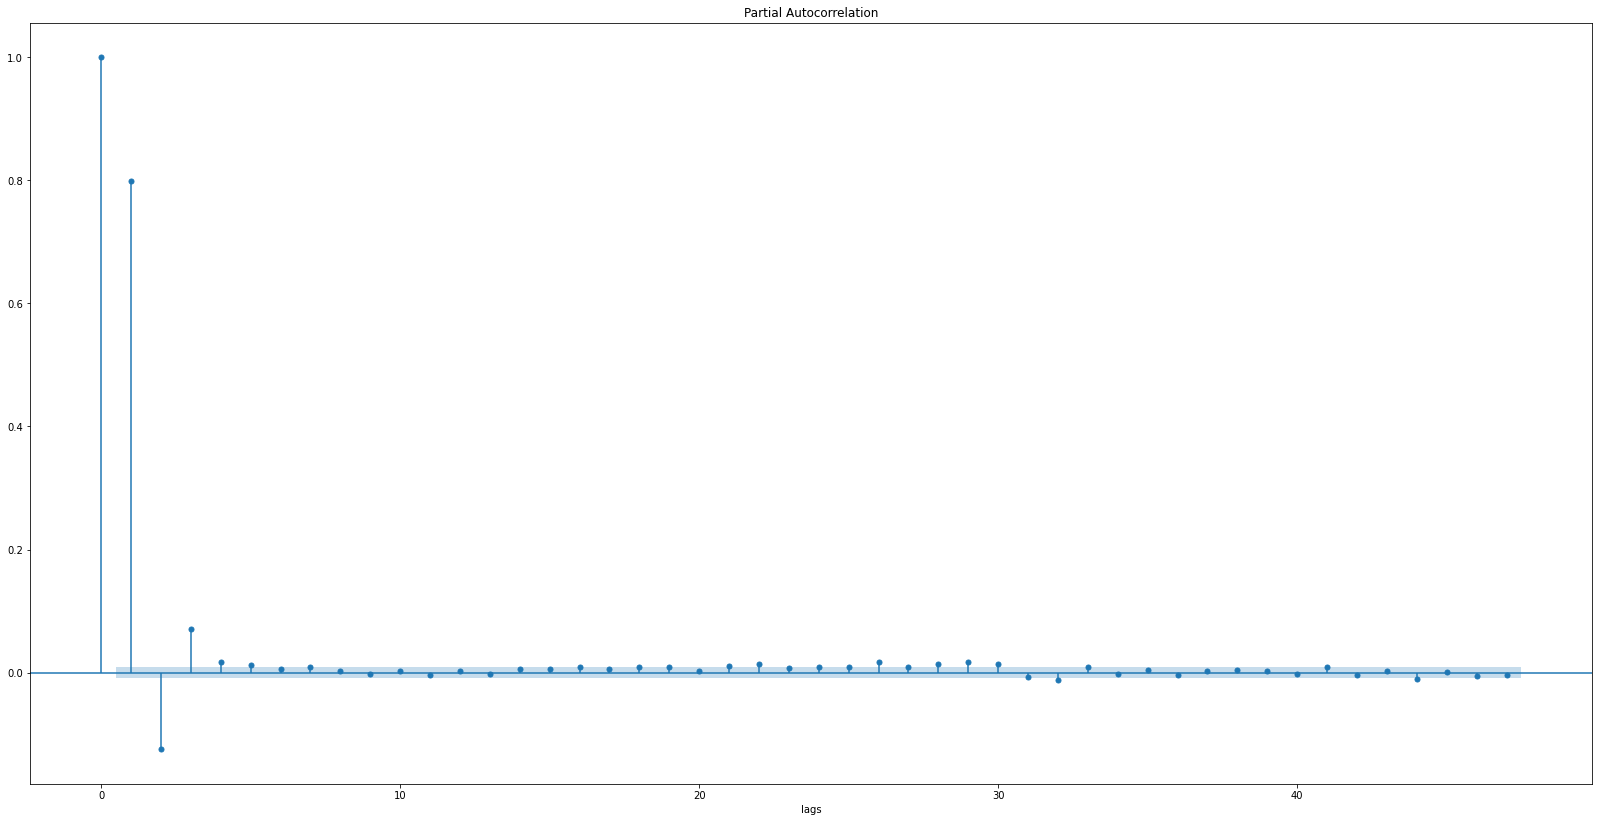

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(remainder['remainder'])
plt.xlabel('lags')

plt.show()

In [60]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
# inputs are time series as a pandas series and a max lag

selected_order = ar_select_order(remainder_copy['remainder'], maxlag=12)
selected_order.ar_lags

array([1, 2, 3, 4])

In [67]:
stats_ar1 = AutoReg(remainder_copy['remainder'], lags=4).fit()


In [ ]:
stats_ar1.summary()

In [68]:
stats_ar1.predict()

date
1901-01-01   NaN
1901-01-02   NaN
1901-01-03   NaN
1901-01-04   NaN
1901-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Length: 43269, dtype: float64

In [66]:
remainder['prediction_ar1']

date
1901-01-02   -6.154667
1901-01-03   -8.996524
1901-01-04   -9.756690
1901-01-05   -8.826023
1901-01-06   -7.530776
                ...   
2019-12-27    1.643414
2019-12-28    0.281599
2019-12-29   -1.384418
2019-12-30   -2.250027
2019-12-31    1.826705
Name: prediction_ar1, Length: 43268, dtype: float64